In [100]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ECE570/FinalProject/RegluarLRNN-master')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arithmetic.ipynb     cycle.csv	  cycle.py		pair.csv    __pycache__
arith_sequences.csv  Cycle.ipynb  DataGeneration.ipynb	Pair.ipynb  README.md


In [101]:
import torch
import torch.nn as nn
import math

import torch
import torch.nn as nn
import argparse

# !pip install torch --upgrade
# from torch._dynamo.utils import CompileProfiler
# prof = CompileProfiler()
from torch.utils.data import DataLoader, TensorDataset
torch.set_float32_matmul_precision('high')

from google.colab import files
import csv
#files.download('/content/arith_sequences.csv')

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import math

In [103]:
class BlockModel(nn.Module):
    def __init__(self, M = 2, emb_dim=8, block_dim=2):
        super().__init__()

        self.M = M
        self.emb_dim = emb_dim
        self.block_dim = block_dim
        h = emb_dim//block_dim

        self.gen_block = nn.Sequential(
                            nn.Linear(emb_dim, emb_dim*block_dim),
                            nn.ReLU(),
                            nn.Linear(emb_dim*block_dim, emb_dim*block_dim),
                            )

        self.gen_value = nn.Sequential(
                            nn.Linear(emb_dim, emb_dim),
                            nn.ReLU(),
                            nn.Linear(emb_dim, emb_dim),
                            )

        self.a0 = nn.Parameter( torch.randn(1, h, block_dim) )

    def compute_hidden_state(self, input_data):
        batch_size = input_data.size(0)
        seq_length = input_data.size(1)
        num_blocks = self.emb_dim // self.block_dim  # Calculate the number of blocks

        # Generate blocks and reshape for further operations
        reshaped_blocks = self.gen_block(input_data)
        reshaped_blocks = reshaped_blocks.view(batch_size, seq_length, num_blocks, self.block_dim, self.block_dim)

        # Normalize the blocks by subtracting the mean and normalizing the scale
        block_means = reshaped_blocks.mean(dim=-2, keepdim=True)
        normalized_blocks = reshaped_blocks - block_means
        block_norms = normalized_blocks.norm(dim=-2, p=1.2, keepdim=True)
        max_norms = block_norms.max(dim=-1, keepdim=True)[0]
        normalized_blocks = normalized_blocks / max_norms

        # Generate values and reshape accordingly
        generated_values = self.gen_value(input_data).view(batch_size, seq_length, num_blocks, self.block_dim)

        # Initialize the hidden state using the parameter a0 expanded to match the batch size
        current_state = self.a0.expand(batch_size, -1, -1)  # Shape: (batch_size, num_blocks, block_dim)
        sequence_hidden_states = []  # Store all hidden states for concatenation

        # Iterate through the sequence
        for t in range(seq_length):
            # Compute the new hidden state using einsum for matrix multiplication
            updated_state = torch.einsum('bnij,bnj->bni', normalized_blocks[:, t], current_state)
            updated_state += generated_values[:, t]
            sequence_hidden_states.append(updated_state.view(batch_size, 1, self.emb_dim))  # Append the reshaped state

        # Concatenate all hidden states across the sequence dimension
        final_hidden_states = torch.cat(sequence_hidden_states, dim=1)

        return final_hidden_states



    def get_hidden_with_v_and_pscan(self, input_data):
        def process_groups(input_tensor, matrix_set):
            # Compute the split size for reshaping
            split_size = matrix_set.shape[2] * 2
            # Split the reshaped input into two parts
            reshaped_input = input_tensor.view(batch_size, padded_length // split_size, split_size, num_blocks, -1)
            first_half, second_half = reshaped_input[:, :, :split_size // 2], reshaped_input[:, :, split_size // 2:]
            # Ensure that the matrix set has the correct shape for this operation
            assert matrix_set.shape[1] % 2 == 1, 'The second dimension of matrix_set must be 2^k - 1 for k >= 1'
            # Select alternating coefficients and remaining matrices
            coefficient_matrices = matrix_set[:, ::2]
            residual_matrices = matrix_set[:, 1::2]

            # Perform einsum to compute products for residuals
            product_result = torch.einsum('bnchij,bnhjk->bnchik', coefficient_matrices[:, 1:], residual_matrices[:, :, -1])
            # Concatenate residual matrices with product results
            updated_residuals = torch.cat([residual_matrices, product_result], dim=2)
            # Update the second half of the input tensor using the coefficient matrices and the last part of the first half
            second_half += torch.einsum('bnchij,bnhj->bnchi', coefficient_matrices, first_half[:, :, -1])
            # Combine both halves back together
            final_result = torch.cat([first_half, second_half], dim=2)
            return final_result, updated_residuals


        batch_size = input_data.size(0)
        seq_length = input_data.size(1)
        num_blocks = self.emb_dim // self.block_dim  # Calculate the number of blocks

        # Generate blocks and reshape for further operations
        reshaped_blocks = self.gen_block(input_data)
        reshaped_blocks = reshaped_blocks.view(batch_size, seq_length, num_blocks, self.block_dim, self.block_dim)

        # Normalize the blocks by subtracting the mean and normalizing the scale
        block_means = reshaped_blocks.mean(dim=-2, keepdim=True)
        normalized_blocks = reshaped_blocks - block_means
        block_norms = normalized_blocks.norm(dim=-2, p=1.2, keepdim=True)
        max_norms = block_norms.max(dim=-1, keepdim=True)[0]
        normalized_blocks = normalized_blocks / max_norms

        # Generate values and reshape accordingly
        generated_values = self.gen_value(input_data).view(batch_size, seq_length, num_blocks, self.block_dim)

        # Calculate the next power of 2 greater than or equal to seq_length + 1
        log2_length = int(math.ceil(math.log2(seq_length + 1)))
        padded_length = 2**log2_length  # Final length after zero padding
        num_zeros = padded_length - seq_length - 1  # Calculate how many zeros to pad

        # Concatenate the initial value (a0) with generated values, and pad with zeros
        expanded_values = torch.cat([self.a0.expand(batch_size, -1, -1)[:, None, :, :], generated_values], dim=1)
        expanded_values = nn.functional.pad(expanded_values, (0, 0, 0, 0, 0, num_zeros))

        # Pad the normalized blocks and reshape for processing
        padded_blocks = nn.functional.pad(normalized_blocks, (0, 0, 0, 0, 0, 0, 0, num_zeros))[:, :, None, :, :, :]

        # Process the groups iteratively
        for _ in range(log2_length):
            aexpanded_values, padded_blocks = process_groups(expanded_values, padded_blocks)

        # Reshape and slice the result to match the original sequence length
        expanded_values = expanded_values.view(batch_size, padded_length, self.emb_dim)[:, 1:seq_length + 1]

        return expanded_values





In [104]:
M = 5
seq_len = 39  # Ensure seq_len is odd

def read_and_split_data(file_path, seq_len, test_size=0.2, random_state=42):
    """
    Reads the CSV file containing sequences and answers, and splits them into training and test sets.
    Ensures the correct shape for the answers based on the sequence length.
    """
    df = pd.read_csv(file_path, header=None)

    # Separate sequences and answers
    sequences = df.iloc[::2].values  # Extract every other row starting from the first (sequences)
    answers = df.iloc[1::2].values   # Extract every other row starting from the second (answers)

    # Only keep the correct number of answers ((seq_len + 1) // 2)
    correct_num_answers = (seq_len + 1) // 2
    answers = answers[:, :correct_num_answers]  # Truncate the answers to the correct size

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, answers, test_size=test_size, random_state=random_state)

    # Convert NumPy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.int64)
    X_test = torch.tensor(X_test, dtype=torch.int64)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    return X_train, X_test, y_train, y_test


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
file_path = '/content/drive/MyDrive/ECE570/FinalProject/RegluarLRNN-master/cycle.csv'

# Read and split the data
X_train, X_test, y_train, y_test = read_and_split_data(file_path, seq_len, test_size=0.2)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Check the shapes of the training and testing sets
print("Training sequences shape:", X_train.shape)
print("Test sequences shape:", X_test.shape)
print("Training answers shape:", y_train.shape)
print("Test answers shape:", y_test.shape)


# Compare types
print("CSV training sequences type:", X_train.dtype)
print("CSV training answers type:", y_train.dtype)

print(X_test[0])
print(y_test[0])


Training sequences shape: torch.Size([4096000, 40])
Test sequences shape: torch.Size([1024000, 40])
Training answers shape: torch.Size([4096000, 20])
Test answers shape: torch.Size([1024000, 20])
CSV training sequences type: torch.int64
CSV training answers type: torch.int64
tensor([2, 0, 2, 3, 2, 1, 0, 2, 0, 1, 4, 0, 4, 1, 1, 1, 2, 0, 4, 0, 3, 3, 2, 0,
        2, 0, 4, 0, 3, 4, 4, 4, 4, 0, 2, 1, 4, 3, 0, 4])
tensor([2, 2, 4, 2, 4, 0, 0, 2, 2, 3, 2, 2, 1, 2, 3, 4, 1, 1, 0, 0])


In [105]:
class CycleMultiBlock(nn.Module):
    def __init__(self, M = 5, emb_dim=32, block_dim=2, n_layers=1):
        super().__init__()

        self.layers = nn.ModuleList()
        self.ln = nn.ModuleList()
        self.ln_final = nn.LayerNorm(emb_dim)
        self.embedding = nn.Embedding(M, emb_dim)
        for i in range(n_layers):
            self.layers.append(BlockModel(M=M, emb_dim=emb_dim, block_dim=block_dim))
            self.ln.append( nn.LayerNorm(emb_dim) )
        self.Wo1 = nn.Linear(emb_dim, emb_dim)
        self.Wo2 = nn.Linear(emb_dim, M)

    def forward(self, input_x):
        a = self.embedding(input_x)
        for i in range(len(self.layers)-1):
            out = self.layers[i].get_hidden_with_v_and_pscan(self.ln[i](a))
            a = out + a
        a = self.layers[-1].get_hidden_with_v_and_pscan(self.ln[-1](a))
        a = self.ln_final(a)
        return self.Wo2(self.Wo1(a).relu())

In [113]:
#hyperparameters
M = 5
emb_dim = 64
block_dim = 8
n_layers = 3
torch.manual_seed(1)
batch_size = 128
train_len = 40
test_len = 500
iters = 40000
lr = 2e-4
weight_decay = 0.0

In [114]:
model = CycleMultiBlock(M, emb_dim, block_dim, n_layers=n_layers)
model = model.to(device)
uncompiled_model = model
model = torch.compile(model, backend='inductor')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [116]:
# Create TensorDataset and DataLoader for mini-batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Adjust batch_size as needed

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128)

# Fetch one batch from the train and test loaders to inspect their sizes
batch_X_train, batch_y_train = next(iter(train_loader))
batch_X_test, batch_y_test = next(iter(test_loader))

# Print the sizes of the first batch of training and test data
print(f"batch_X_train size: {batch_X_train.size()}")
print(f"batch_y_train size: {batch_y_train.size()}")
print(f"batch_X_test size: {batch_X_test.size()}")
print(f"batch_y_test size: {batch_y_test.size()}")

# Lists to store loss and accuracy for each batch
train_losses = []
test_accuracies = []

# Training loop with mini-batches
max_acc = 0.0
for epoch in range(1):  # For now we are using one epoch for simplicity
    model.train()  # Set model to training mode

    # Iterate over mini-batches
    for batch_idx, (batch_X_train, batch_y_train) in enumerate(train_loader):
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)

        # Forward pass: Get model predictions for the current batch
        predictions = model(batch_X_train)[:, ::2]

        # Compute the loss
        loss = torch.nn.functional.cross_entropy(predictions.flatten(end_dim=1), batch_y_train.flatten(end_dim=1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store batch loss for training
        train_losses.append(loss.item())  # Store loss for each batch

        # Evaluate after each batch (on test set)
        model.eval()  # Set model to evaluation mode
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            # Fetch one batch from the test loader
            batch_X_test, batch_y_test = next(iter(test_loader))

            # Move the batch to the appropriate device
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)

            # Forward pass on the single test batch
            logits_test = model(batch_X_test)[:, -1]  # Assuming you're only interested in the last output
            pred = logits_test.argmax(dim=-1)

            # Calculate accuracy for the single batch
            correct = (pred == batch_y_test[:, -1]).float().sum()
            total_correct = correct
            total_samples = batch_X_test.size(0)

            # Calculate accuracy for this one batch
            accuracy = total_correct / total_samples


        # Calculate accuracy for the current batch
        acc = total_correct / total_samples
        test_accuracies.append(acc.item())  # Store accuracy for each batch

        if len(test_accuracies) >= 20 and all(acc == 1.0 for acc in test_accuracies[-20:]):
            print(f"Stopping early after {batch_idx + 1} batches due to 20 consecutive perfect accuracy batches.")
            break


        if batch_idx >= 1000:
            print(f"Stopping early after {batch_idx + 1} batches due to no convergence.")
            break
        # Print the loss and accuracy for each batch
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Accuracy: {acc.item():.4f}, Loss: {loss.item():.4f}")

        # Track the maximum accuracy achieved
        max_acc = max(acc, max_acc)


batch_X_train size: torch.Size([128, 40])
batch_y_train size: torch.Size([128, 20])
batch_X_test size: torch.Size([128, 40])
batch_y_test size: torch.Size([128, 20])
Epoch 1, Batch 1, Accuracy: 0.1719, Loss: 0.2274
Epoch 1, Batch 2, Accuracy: 0.1484, Loss: 0.1947
Epoch 1, Batch 3, Accuracy: 0.1875, Loss: 0.2399
Epoch 1, Batch 4, Accuracy: 0.2734, Loss: 0.2338
Epoch 1, Batch 5, Accuracy: 0.2578, Loss: 0.2048
Epoch 1, Batch 6, Accuracy: 0.1953, Loss: 0.2745
Epoch 1, Batch 7, Accuracy: 0.1875, Loss: 0.2561
Epoch 1, Batch 8, Accuracy: 0.1562, Loss: 0.2404
Epoch 1, Batch 9, Accuracy: 0.2578, Loss: 0.2876
Epoch 1, Batch 10, Accuracy: 0.2891, Loss: 0.2233
Epoch 1, Batch 11, Accuracy: 0.2812, Loss: 0.3131
Epoch 1, Batch 12, Accuracy: 0.1953, Loss: 0.2258
Epoch 1, Batch 13, Accuracy: 0.1875, Loss: 0.2314
Epoch 1, Batch 14, Accuracy: 0.2109, Loss: 0.2145
Epoch 1, Batch 15, Accuracy: 0.2266, Loss: 0.2586
Epoch 1, Batch 16, Accuracy: 0.1953, Loss: 0.2142
Epoch 1, Batch 17, Accuracy: 0.2344, Loss: 

train losses: [0.2273644506931305, 0.19465243816375732, 0.23986005783081055, 0.23376338183879852, 0.20484516024589539, 0.27446240186691284, 0.25610771775245667, 0.24036988615989685, 0.2876347303390503, 0.2233472764492035, 0.31311261653900146, 0.22581815719604492, 0.23144543170928955, 0.2145250141620636, 0.25861090421676636, 0.21418380737304688, 0.19150660932064056, 0.21007247269153595, 0.20363891124725342, 0.20349431037902832, 0.207879900932312, 0.21406130492687225, 0.20662188529968262, 0.19287684559822083, 0.21681246161460876, 0.18935038149356842, 0.20313577353954315, 0.20888182520866394, 0.20362308621406555, 0.18714912235736847, 0.2086772918701172, 0.2124028503894806, 0.1962207853794098, 0.1751757264137268, 0.16016785800457, 0.19224956631660461, 0.1666106879711151, 0.18252812325954437, 0.1644759178161621, 0.1908448040485382, 0.16403958201408386, 0.1726396083831787, 0.15622730553150177, 0.19730375707149506, 0.17089299857616425, 0.1762388050556183, 0.1877155303955078, 0.197006389498710

<Figure size 800x500 with 0 Axes>

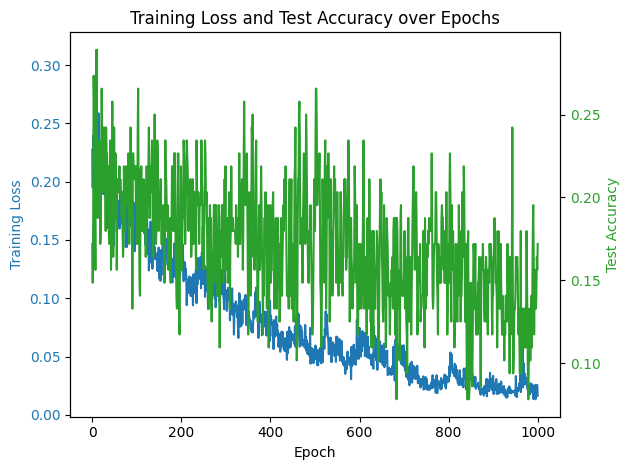

In [117]:
import matplotlib.pyplot as plt

# Plot loss and accuracy at the end of training
print(f"train losses: {train_losses}")
print(f"test accuracies: {test_accuracies}")
print(f"max accuracy: {max_acc}")

plt.figure(figsize=(8, 5))

# Create a plot with two y-axes
fig, ax1 = plt.subplots()

# Plot training loss on the first y-axis (left)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='tab:blue')
ax1.plot(train_losses, label="Training Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis (right) for test accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Test Accuracy', color='tab:green')
ax2.plot(test_accuracies, label="Test Accuracy", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add titles and labels
plt.title("Training Loss and Test Accuracy over Epochs")

fig.tight_layout()  # Prevent overlapping of labels
plt.show()
